In [ ]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular
from dotenv import load_dotenv

import warnings
warnings.filterwarnings('ignore')

# --- Path Configuration ---
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

load_dotenv()

from src.database import AQIDatabase

plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.family'] = 'sans-serif'

print(f"Working Directory: {os.getcwd()}")


Working Directory: d:\Internships\10Pearls\10Pearls-AQI


### 1. Load Resources

We load the historical data from MongoDB and the best-performing model (`model.pkl`) that was saved during the training pipeline.

In [ ]:
# 1. Load Data
try:
    db = AQIDatabase()
    df = db.fetch_data()
    
    # Preprocess
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        df = df.sort_index()
    
    # Fill missing values
    df = df.ffill()
    
    # --- RE-ENGINEER FEATURES (Must match training exactly) ---
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    
    # Rolling Features
    for col in ['pm2_5', 'pm10', 'us_aqi']:
        df[f'{col}_rolling_6h'] = df[col].rolling(6).mean()
        df[f'{col}_rolling_24h'] = df[col].rolling(24).mean()
        
    # Lag Features (The missing one was here!)
    df['lag_1h_aqi'] = df['us_aqi'].shift(1)
    df['lag_2h_aqi'] = df['us_aqi'].shift(2)   # <--- Added this missing feature
    df['lag_24h_aqi'] = df['us_aqi'].shift(24)
    
    # Drop NaN created by lags/rolling
    df = df.dropna()
    
    print(f"✅ Data Loaded. Shape: {df.shape}")

except Exception as e:
    print(f"❌ Data Load Error: {e}")

# 2. Load Model & Features List
try:
    with open('models/model.pkl', 'rb') as f:
        model = pickle.load(f)
        
    with open('models/features.pkl', 'rb') as f:
        feature_names = pickle.load(f)
        
    print(f"✅ Model Loaded: {type(model).__name__}")
    print(f"✅ Features Expected: {feature_names}")
    
    # Double check if all features exist in df
    missing_cols = [col for col in feature_names if col not in df.columns]
    if missing_cols:
        print(f"❌ WARNING: Still missing features: {missing_cols}")
    else:
        print("✅ All features present!")
    
except Exception as e:
    print(f"❌ Model Load Error: {e}")


Connected to MongoDB.
✅ Data Loaded. Shape: (4440, 19)
✅ Model Loaded: LinearRegression
✅ Features Expected: ['hour', 'day_of_week', 'month', 'pm10_rolling_24h', 'pm10_rolling_6h', 'pm2_5_rolling_24h', 'pm2_5_rolling_6h', 'us_aqi_rolling_24h', 'us_aqi_rolling_6h', 'lag_1h_aqi', 'lag_2h_aqi', 'lag_24h_aqi']
✅ All features present!


### 2. SHAP Analysis (Global Interpretability)

We initialize the appropriate SHAP explainer based on the model type (TreeExplainer for XGBoost/RandomForest, LinearExplainer for Regression).


In [ ]:
# Prepare Input Data (X)
X = df[feature_names]

# Initialize SHAP Explainer
if 'XGBRegressor' in str(type(model)) or 'RandomForestRegressor' in str(type(model)):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    print("Using TreeExplainer")
elif 'LinearRegression' in str(type(model)):
    # Use a sample for Linear explainer to be faster
    masker = shap.maskers.Independent(X, max_samples=100)
    explainer = shap.LinearExplainer(model, masker)
    shap_values = explainer.shap_values(X)
    print("Using LinearExplainer")
else:
    # Fallback for other models
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)

print("SHAP Values Calculated.")


Using LinearExplainer
SHAP Values Calculated.


### 3. Feature Impact Summary

The **Beeswarm Plot** is the most information-dense visualization.

* **Y-Axis:** Features ranked by importance.
* **X-Axis:** Impact on AQI (positive or negative).
* **Color:** Feature Value (Red = High, Blue = Low).

*Insight: If 'pm2_5' is red (high value) and is on the right side, it means high PM2.5 heavily increases the predicted AQI.*

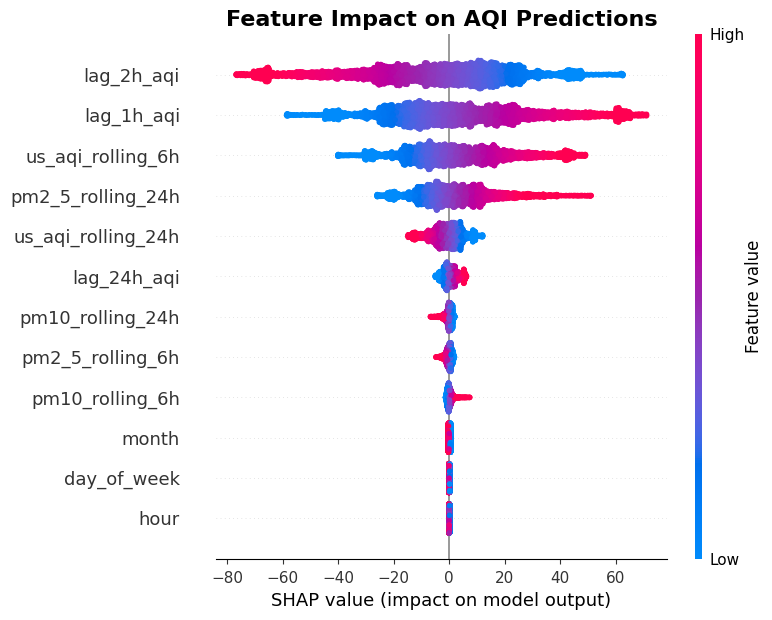

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Feature Impact on AQI Predictions", fontsize=16, fontweight='bold')

# Summary Plot
shap.summary_plot(shap_values, X, show=False, plot_type="dot")

plt.tight_layout()
plt.show()


### 4. Mean Feature Importance

This bar chart simplifies the analysis by showing the average absolute impact of each feature. It clearly identifies the "Top 5 Drivers" of air quality in your model.


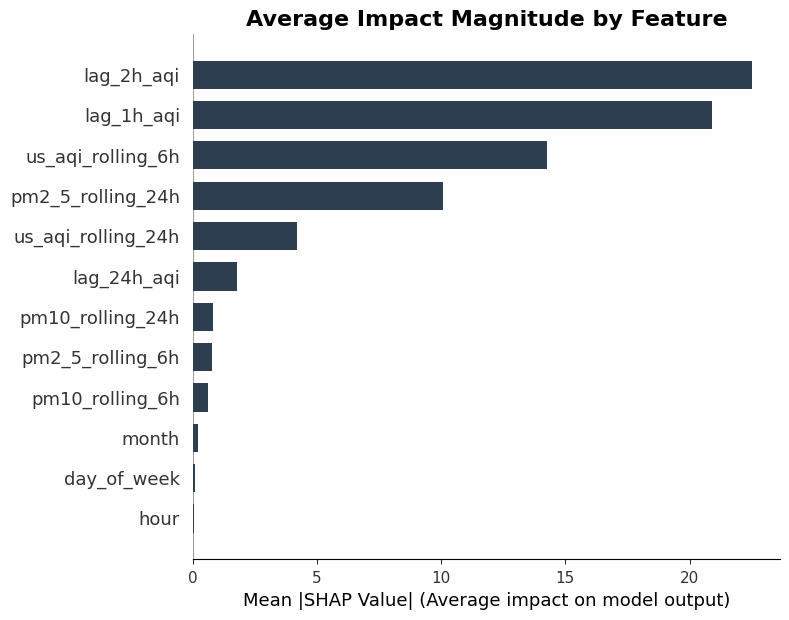

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Average Impact Magnitude by Feature", fontsize=16, fontweight='bold')

shap.summary_plot(shap_values, X, plot_type="bar", show=False, color='#2c3e50')

plt.xlabel("Mean |SHAP Value| (Average impact on model output)")
plt.tight_layout()
plt.show()


### 5. Feature Dependence (Non-Linearity)

We analyze the relationship between the **most important feature** (automatically selected) and the model output. This reveals if the relationship is linear or if there are thresholds where pollution spikes.


Top Feature identified: lag_2h_aqi


<Figure size 1000x600 with 0 Axes>

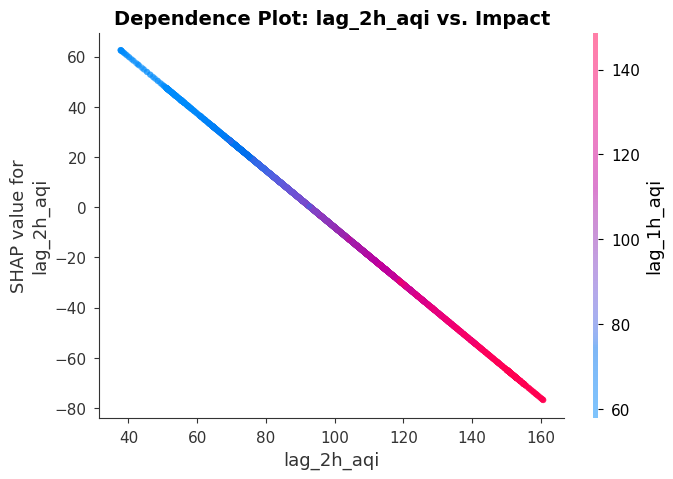

In [ ]:
# Identify top feature
if isinstance(shap_values, list): # Handle some sklearn outputs
    vals = np.abs(shap_values).mean(0)
else:
    vals = np.abs(shap_values).mean(0)
    
top_feature_idx = np.argsort(vals)[-1]
top_feature_name = feature_names[top_feature_idx]

print(f"Top Feature identified: {top_feature_name}")

# Dependence Plot
plt.figure(figsize=(10, 6))
shap.dependence_plot(top_feature_name, shap_values, X, show=False, alpha=0.5, dot_size=20)

plt.title(f"Dependence Plot: {top_feature_name} vs. Impact", fontsize=14, fontweight='bold')
plt.show()


### 6. LIME Analysis (Local Explanation)

While SHAP explains the *whole* model, **LIME** explains *one specific prediction*.
We select a specific high-pollution scenario (e.g., the highest AQI day in the dataset) and ask the model: *"Why did you predict such a high value for this specific hour?"*


Analyzing High Pollution Scenario:
Date: 2025-11-01 12:00:00
Actual AQI: 160.69955444335938


<Figure size 1000x600 with 0 Axes>

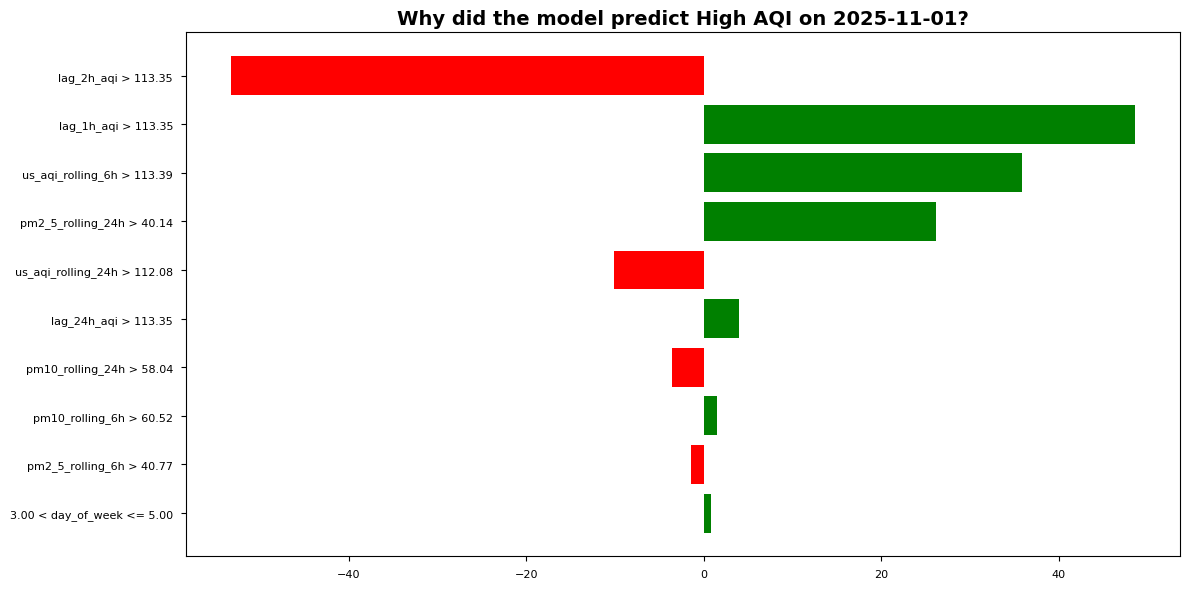

In [ ]:
# 1. Initialize LIME Explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X),
    feature_names=feature_names,
    class_names=['us_aqi'],
    mode='regression'
)

# 2. Pick a specific instance (e.g., The hour with the highest AQI)
max_aqi_idx = df['us_aqi'].argmax()
instance = X.iloc[max_aqi_idx]
actual_val = df['us_aqi'].iloc[max_aqi_idx]

print(f"Analyzing High Pollution Scenario:")
print(f"Date: {df.index[max_aqi_idx]}")
print(f"Actual AQI: {actual_val}")

# 3. Generate Explanation
exp = explainer_lime.explain_instance(
    data_row=instance, 
    predict_fn=model.predict
)

# 4. Plot
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.title(f"Why did the model predict High AQI on {df.index[max_aqi_idx].date()}?", fontweight='bold')
plt.tight_layout()
plt.show()


### 7. SHAP Waterfall Plot

A Waterfall plot is the gold standard for explaining a single prediction. It starts at the baseline (average AQI) and shows how each feature pushes the prediction up (red) or down (blue) to reach the final value.


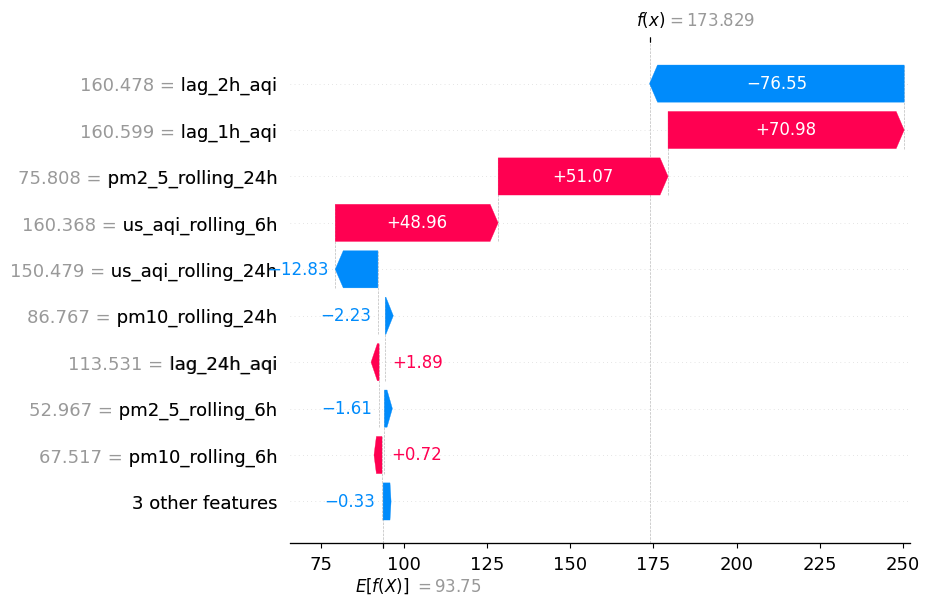

In [ ]:
# For Linear Models, we construct a generic Explainer just for this plot if needed
try:
    # Try generic waterfall
    shap.waterfall_plot(shap.Explanation(values=shap_values[max_aqi_idx], 
                                         base_values=explainer.expected_value, 
                                         data=X.iloc[max_aqi_idx], 
                                         feature_names=feature_names))
except:
    # If using Linear/Tree explainer specific format
    print("Generating Waterfall for specific instance...")
    plt.figure()
    shap.plots.waterfall(shap.Explanation(values=shap_values[max_aqi_idx], 
                                         base_values=explainer.expected_value, 
                                         data=X.iloc[max_aqi_idx], 
                                         feature_names=feature_names),
                        show=False)
    plt.title("Prediction Breakdown (Waterfall Chart)", fontsize=14, fontweight='bold')
    plt.show()


---

### **Key Interpretability Insights**

In [ ]:
# Key Interpretability Insights

from sklearn.metrics import r2_score, mean_squared_error

    mean_shap = np.abs(shap_values[0]).mean(0)
else:
    mean_shap = np.abs(shap_values).mean(0)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_shap
}).sort_values('importance', ascending=False)

X_subset = df[feature_names]
y_subset = df['us_aqi']
preds = model.predict(X_subset)
r2 = r2_score(y_subset, preds)
rmse = np.sqrt(mean_squared_error(y_subset, preds))

print("="*70)
print(f"SHAP ANALYSIS SUMMARY - {type(model).__name__.upper()}")
print("="*70)

print("\n" + "-"*70)
print("MODEL PERFORMANCE (Current Loaded Model):")
print("-"*70)
print(f"  ACCURACY (R²): {r2:.4f}")
print(f"  ERROR (RMSE):  {rmse:.4f}")

print("\n" + "-"*70)
print("TOP 5 MOST INFLUENTIAL FEATURES (Ranked by SHAP Importance):")
print("-"*70)

for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
    print(f"  {i}. {row['feature']}")
    print(f"     Impact Score: {row['importance']:.4f}")

print("\n" + "-"*70)
print("INTERPRETATION:")
print("-"*70)
print(f"""
• Primary Driver: '{importance_df.iloc[0]['feature']}' is the strongest predictor of Air Quality.
• Higher SHAP values indicate a stronger push (positive or negative) on the final AQI.
• Rolling Averages (e.g., 24h) capture the accumulated pollution levels.
• Lag Features (e.g., lag_1h) allow the model to adjust based on immediate history.
• This model relies heavily on {importance_df.iloc[0]['feature']} and {importance_df.iloc[1]['feature']}.
""")

# print("\n" + "="*70)
print("="*70)


SHAP ANALYSIS SUMMARY - LINEARREGRESSION

----------------------------------------------------------------------
MODEL PERFORMANCE (Current Loaded Model):
----------------------------------------------------------------------
  ACCURACY (R²): 0.9849
  ERROR (RMSE):  3.0572

----------------------------------------------------------------------
TOP 5 MOST INFLUENTIAL FEATURES (Ranked by SHAP Importance):
----------------------------------------------------------------------
  1. lag_2h_aqi
     Impact Score: 22.5130
  2. lag_1h_aqi
     Impact Score: 20.9186
  3. us_aqi_rolling_6h
     Impact Score: 14.2607
  4. pm2_5_rolling_24h
     Impact Score: 10.0767
  5. us_aqi_rolling_24h
     Impact Score: 4.1856

----------------------------------------------------------------------
INTERPRETATION:
----------------------------------------------------------------------

• Primary Driver: 'lag_2h_aqi' is the strongest predictor of Air Quality.
• Higher SHAP values indicate a stronger push (posit